In [1062]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Standard

timeframe= '30min'
trading_sessions_per_day= 13
option_type="C"
risk_free_rate=0.05

In [ ]:
#Math Logic

# Black-Scholes formula
def black_scholes_price(S, K, T, r, sigma, option_type="C"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "C":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "P":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied Volatility using Newton Raphson
def calculate_iv(option_price, S, K, T, r, option_type="C"):
    def bs_error(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - option_price
    try:
        return brentq(bs_error, 1e-6, 3)  
    except ValueError:
        return np.nan  

#Find z-score for mean reversion
def calculate_zscore(data, lookback):
    mean = data.rolling(window=lookback).mean()
    std = data.rolling(window=lookback).std()
    zscore = (data - mean) / std
    return zscore

#Calculates sharpe for a pnl series
def calculate_sharpe_ratio(returns, period='y'):
    if period=='d':
        return returns.mean()/returns.std()
    sharpe_ratio= (returns.mean() - risk_free_rate)* np.sqrt(252) / returns.std()
    return sharpe_ratio

#Max drawdown of a pnl series
def calculate_drawdown(returns):
  cumulative_returns = returns.cumsum()
  peak = cumulative_returns.cummax()
  drawdown = cumulative_returns - peak
  return drawdown.min()

In [890]:
# Data operations

#Load Data, Can do in chunks incase of system crashes
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['start_ts'], usecols=['symbol','start_ts','open','high','low','close','volume','vwap'])
    data = data.dropna()
    return data

def strip_extra_trading_hours(data):
    
    data=data.reset_index()

    data = data.drop(data[data['start_ts'].dt.time< time(9,30,0)].index)
    data = data.drop(data[data['start_ts'].dt.time>= time(16,0,0)].index)

    return data

'''Filter the Data
    1. Convert to 30min timeframe
    2. Strip off extra trading hours
'''
def convert_eqt_data(eqt,new_timeframe):  

    eqt = eqt.set_index('start_ts')

    eqt_data = eqt.resample(new_timeframe).agg(    
        close= ('close', 'last'),
        Weighed_Price_Volume= ('vwap', lambda x:(x* eqt.loc[x.index, 'volume']).sum()),
        volume= ('volume','sum'),
        symbol= ('symbol','last')
    )

    eqt_data['vwap'] = eqt_data['Weighed_Price_Volume']/eqt_data['volume']
    eqt_data=eqt_data.drop(columns=['Weighed_Price_Volume'])

    #Strip off extra trading hours
    eqt_data=strip_extra_trading_hours(eqt_data)

    eqt_data= eqt_data.reset_index()
    eqt_data = eqt_data.dropna()
    return eqt_data

def data_filtering(option):

    #Add columns 
    option_characteristics=pd.DataFrame((x.split('_') for x in option['symbol']), columns=['ticker','expiry_date','strike_price','option_type'])
    option_characteristics['expiry_date']=pd.to_datetime(option_characteristics['expiry_date'])
    option_characteristics['strike_price']= option_characteristics['strike_price'].astype(float)
    option=pd.concat([option,option_characteristics],axis=1)

    #Call calendar 
    option=option.drop(option[option['option_type']=='P'].index)

    option=option.reset_index()

    return option

#Create a close price mapping for all valid options
def convert_option_data(option,new_timeframe):  

    option_close= option.pivot(index='start_ts', columns='symbol', values='close')
    option_close= option_close.resample(new_timeframe).last()
    option_close= strip_extra_trading_hours(option_close)    

    # Volume feature
    # option_volume= option.pivot(index='start_ts', columns='symbol', values='volume')
    # option_volume= option_volume.resample(new_timeframe).sum()
    # option_volume= strip_extra_trading_hours(option_volume)         

    return option_close

def precompute_spread(eqt, option_close, option_all):

    spread=pd.DataFrame()

    option_close=option_close.set_index('start_ts')

    for _,rows in eqt.iterrows():
        symbol=rows['symbol']
        start_ts=rows['start_ts']
        spot_price=rows['close']
        
        #This ensures we have no 0 DTE!
        valid_expires = option_all[option_all['expiry_date'] > rows['start_ts']]
        closest_expires= valid_expires['expiry_date'].unique()[:2]
        #Choose closest expiries
        near_expiry= str(closest_expires[0].date().strftime("%Y%m%d"))
        far_expiry= str(closest_expires[1].date().strftime("%Y%m%d"))

        #ATM strike selection
        otm_strikes= option_all[option_all['strike_price'] >= spot_price]
        nearest_atm_strike= int(otm_strikes.iloc[0]['strike_price'])

        option1=f"{symbol}_{near_expiry}_{nearest_atm_strike}_C"
        option2=f"{symbol}_{far_expiry}_{nearest_atm_strike}_C"

        option1_price= option_close.loc[start_ts,option1]
        option2_price= option_close.loc[start_ts,option2]

        # print(start_ts, option1, option1_price, option2, option2_price)
        
        tte1=(closest_expires[0]- start_ts)/pd.Timedelta(days=365)
        tte2=(closest_expires[1]- start_ts)/pd.Timedelta(days=365)

        iv1=calculate_iv(option1_price, spot_price, nearest_atm_strike, tte1 ,risk_free_rate, 'C')
        iv2=calculate_iv(option2_price, spot_price, nearest_atm_strike, tte2 ,risk_free_rate, 'C')

        temp={}
        temp['start_ts']= start_ts
        temp['option']= option2_price -option1_price
        temp['iv']= iv2 - iv1
        temp['symbol']= f"{option1}*{option2}"
        temp['expiry']=pd.to_datetime(closest_expires[0].strftime('%Y-%m-%d 15:30:00'))
        temp['spot']=spot_price
        
        spread=pd.concat([spread, pd.DataFrame([temp])])

    return spread

#Precomputing lagged spreads to reduce lookup times
def create_lag(option_close_eod):

    option_close_eod_diff=option_close_eod.diff()
    option_close_eod_diff=option_close_eod_diff.reset_index()

    #Ensure format
    option_close_eod_diff['start_ts_shifted']= option_close_eod_diff['start_ts'].shift(1)
    option_close_eod_diff = option_close_eod_diff.dropna(subset=['start_ts_shifted'])
    option_close_eod_diff['start_ts_shifted'] = pd.to_datetime(option_close_eod_diff['start_ts_shifted'])
    option_close_eod_diff=option_close_eod_diff.set_index('start_ts_shifted')

    # Add a new row with NaN values
    option_close_eod_diff.loc[option_close_eod_diff.index[-1] + pd.Timedelta(days=1)] = [np.nan] * (len(option_close_eod_diff.columns))

    return option_close_eod_diff
    

In [935]:
# Feature Engineering
def generate_features(spread, lookback):

    spread['iv_zscore']=calculate_zscore(spread['iv'],lookback)
    spread['price_zscore']=calculate_zscore(spread['option'],lookback)
    
    # Lagged features
    # for lag in range(1, 4):
    #     spread[f'iv_lag{lag}'] = spread['iv'].shift(lag)
    #     spread[f'price_lag{lag}'] = spread['price'].shift(lag)
    #     spread[f'iv_zscore{lag}'] = spread['iv_zscore'].shift(lag)
    
    # # Target: Binary classification -Pnl based on future spread return?
    # spread['pnl'] = (spread['price'].shift(-1) - spread['price']) > 0
    # spread['pnl'] = spread['pnl'].astype(int)
    
    return spread.dropna()

In [1058]:
def generate_signals(spread , option_close, threshold, wt1, wt2):

    last_trade_date=spread.iloc[-1]['start_ts']

    #Precompute calendar EOD spreads
    option_close_eod=option_close[option_close['start_ts'].dt.time == pd.to_datetime('15:30:00').time()]
    option_close_eod= option_close_eod.set_index('start_ts')
    # print(option_close_eod.to_string())

    option_close_eod_diff=create_lag(option_close_eod)
    # print(option_close_eod_diff.to_string())
    
    #Pnl series
    daily_pnl= pd.DataFrame({'start_ts': spread['start_ts'], 'pnl':0.0})
    daily_pnl=daily_pnl[daily_pnl['start_ts'].dt.time == pd.to_datetime('15:30:00').time()]
    daily_pnl.set_index('start_ts',inplace=True)
    daily_pnl.loc[daily_pnl.index[-1] + pd.Timedelta(days=1)] = [np.nan] * (len(daily_pnl.columns))

    for _,rows in spread.iterrows():
        start_ts= rows['start_ts']
        eod_label= start_ts.replace(hour=15, minute=30, second=0)
        symbol= rows['symbol']
        contracts= symbol.split('*')
        eod_price= option_close_eod.loc[eod_label,contracts[1]]-option_close_eod.loc[eod_label,contracts[0]]
        expiry= rows['expiry']
        zscore= wt1*rows['price_zscore']+wt2*rows['iv_zscore']
        price= rows['option']

        # print(start_ts,symbol,eod_price,expiry,zscore,price)

        if expiry > last_trade_date: #No expiry Trades
            break

        if zscore < (-1*threshold): #Long trade

            # print("Long",start_ts,symbol,price,eod_price,expiry,zscore)
            daily_pnl.loc[eod_label,'pnl']+= eod_price - price #Today Pnl

            #Fwd Pnl
            temp_pnl = pd.DataFrame(0.0,index=daily_pnl.index, columns=['pnl'])
            temp_pnl.loc[eod_label:expiry,'pnl']= option_close_eod_diff.loc[eod_label:expiry,contracts[1]]-option_close_eod_diff.loc[eod_label:expiry,contracts[0]]
            temp_pnl['pnl']=temp_pnl['pnl'].shift(1) 
            temp_pnl['pnl']=temp_pnl['pnl'].fillna(0.0)
            daily_pnl['pnl']+=temp_pnl['pnl']

            # print(temp_pnl.to_string(),daily_pnl.to_string())
        elif zscore > threshold: #Short trade

            # print("Short",start_ts,symbol,price,eod_price,expiry,zscore)
            daily_pnl.loc[eod_label,'pnl']+= -(eod_price - price) #Today Pnl

            #Fwd Pnl
            temp_pnl = pd.DataFrame(0.0,index=daily_pnl.index, columns=['pnl'])
            temp_pnl.loc[eod_label:expiry,'pnl']= -(option_close_eod_diff.loc[eod_label:expiry,contracts[1]]-option_close_eod_diff.loc[eod_label:expiry,contracts[0]])
            temp_pnl['pnl']=temp_pnl['pnl'].shift(1) 
            temp_pnl['pnl']=temp_pnl['pnl'].fillna(0.0)
            daily_pnl['pnl']+=temp_pnl['pnl']

            # print(temp_pnl.to_string(),daily_pnl.to_string())

    daily_pnl=daily_pnl.dropna()
    # print(daily_pnl)

    # plt.figure(figsize=(8, 6))
    # plt.plot(daily_pnl.index.date, daily_pnl['pnl'], marker='o', linestyle='-', color='b', label='Daily Pnl')

    return daily_pnl['pnl']

In [1059]:
'''
    Features X =[Lookback, Threshold]
    Results Y=[max(sharpe), max(netpnl), min(dd)]
'''
def model(calendar_spread, option_close, lookback, threshold, wt1, wt2):

    spread_matrix= generate_features(calendar_spread, lookback)
    # print(spread_matrix.to_string())
    
    #Train model on factors now?>
    pnl_series=generate_signals(spread_matrix, option_close, threshold, wt1, wt2)

    cumulative_pnl = pnl_series.cumsum()
    cumulative_pnl=cumulative_pnl.reset_index()
    sharpe = calculate_sharpe_ratio(pnl_series)
    max_drawdown = calculate_drawdown(pnl_series)  

    results= {
        'pnl': cumulative_pnl.iloc[-1]['pnl'],
        'sharpe': sharpe,
        'dd': max_drawdown
    }

    return results


In [1084]:

# Loss Function: Minimize -ve net pnl or -ve sharpe OR minimize max dd
def loss_function(calendar_spread, option_close, lookback, threshold, wt1, wt2):

    # Generate signals and calculate cumulative PnL
    result = model(calendar_spread, option_close, lookback, threshold, wt1, wt2)
    net_pnl = result['pnl']  
    return -1*net_pnl

def gradient_descent(calendar_spread, option_close, lookback, threshold, learning_rate=0.01, epochs=100):

    wt1, wt2 = 0.5,0.5
    loss_history = []

    for epoch in range(epochs):

        delta = 0.05
        current_loss = loss_function(calendar_spread, option_close, lookback, threshold, wt1, wt2)

        grad_wt1 = (loss_function(calendar_spread, option_close, lookback, threshold, wt1+delta, wt2) - current_loss) / delta
        grad_wt2 = (loss_function(calendar_spread, option_close, lookback, threshold, wt1, wt2+delta) - current_loss) / delta

        # print(grad_wt1,grad_wt2)

        wt1 -= learning_rate * grad_wt1
        wt2 -= learning_rate * grad_wt2


        loss_history.append(current_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {current_loss:.4f}, wt1 = {wt1:.4f}, wt2 = {wt2:.4f}")

    return wt1, wt2, loss_history



In [1072]:
'''Equity trading hours from 4am to 8pm'''
eqt_path = 'CBOE Data/testeqt.csv'
eqt = load_data(eqt_path)

# Convert to 30min ticks
eqt_data = convert_eqt_data(eqt,timeframe)
print(eqt_data.to_string())

     index            start_ts     close      volume symbol        vwap
0       11 2023-01-03 09:30:00  126.9336  13683695.0   AAPL  129.271024
1       12 2023-01-03 10:00:00  125.4600  10686686.0   AAPL  126.092497
2       13 2023-01-03 10:30:00  125.5950   9023652.0   AAPL  125.404657
3       14 2023-01-03 11:00:00  125.3400   8429008.0   AAPL  125.209053
4       15 2023-01-03 11:30:00  124.7488   6110185.0   AAPL  124.879579
5       16 2023-01-03 12:00:00  124.6554   4796729.0   AAPL  124.763794
6       17 2023-01-03 12:30:00  124.5900   4015050.0   AAPL  124.626831
7       18 2023-01-03 13:00:00  124.6500   4074701.0   AAPL  124.427184
8       19 2023-01-03 13:30:00  124.8150   4116170.0   AAPL  124.566492
9       20 2023-01-03 14:00:00  124.5726   3589739.0   AAPL  124.678465
10      21 2023-01-03 14:30:00  124.6150   5941235.0   AAPL  124.697510
11      22 2023-01-03 15:00:00  124.6200   5301049.0   AAPL  124.698999
12      23 2023-01-03 15:30:00  125.0200  10287122.0   AAPL  125

In [941]:
'''Options trading hours from 9.30am to 4pm'''
option_path = 'CBOE Data/testopt.csv'
option = load_data(option_path)
option_all= data_filtering(option)

#Convert to 30min ticks
option_close = convert_option_data(option_all,timeframe)
# option_volume = convert_option_data(option_all,timeframe)
# print(option_close.to_string())

#Define calendar spread
spread= precompute_spread(eqt_data,option_close,option_all)
print(spread.to_string())

             start_ts  option        iv                                   symbol              expiry      spot
0 2023-01-03 09:30:00    1.46 -0.118540  AAPL_20230106_127_C*AAPL_20230113_127_C 2023-01-06 15:30:00  126.9336
0 2023-01-03 10:00:00    1.35 -0.143631  AAPL_20230106_126_C*AAPL_20230113_126_C 2023-01-06 15:30:00  125.4600
0 2023-01-03 10:30:00    1.45 -0.118076  AAPL_20230106_126_C*AAPL_20230113_126_C 2023-01-06 15:30:00  125.5950
0 2023-01-03 11:00:00    1.45 -0.114945  AAPL_20230106_126_C*AAPL_20230113_126_C 2023-01-06 15:30:00  125.3400
0 2023-01-03 11:30:00    1.49 -0.117617  AAPL_20230106_125_C*AAPL_20230113_125_C 2023-01-06 15:30:00  124.7488
0 2023-01-03 12:00:00    1.47 -0.117927  AAPL_20230106_125_C*AAPL_20230113_125_C 2023-01-06 15:30:00  124.6554
0 2023-01-03 12:30:00    1.50 -0.115089  AAPL_20230106_125_C*AAPL_20230113_125_C 2023-01-06 15:30:00  124.5900
0 2023-01-03 13:00:00    1.50 -0.122156  AAPL_20230106_125_C*AAPL_20230113_125_C 2023-01-06 15:30:00  124.6500
0

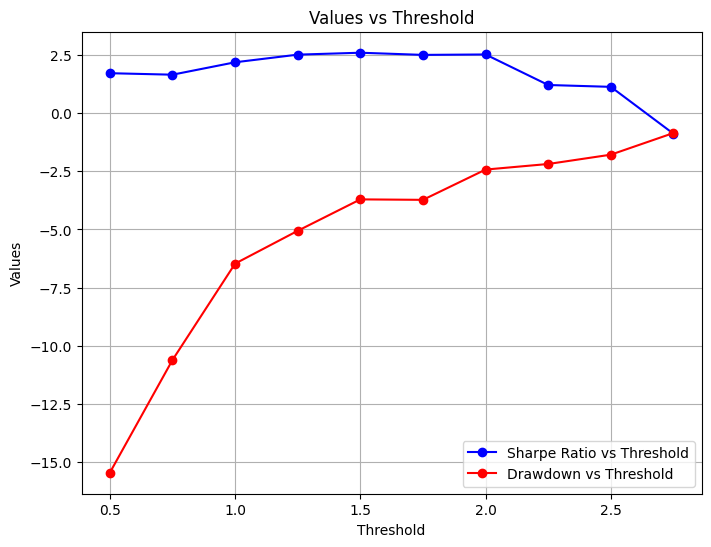

In [997]:
X= np.arange(0.5,3,0.25)
Y1= [model(spread, option_close, lookback=13, threshold=i)['sharpe'] for i in X ]
Y2= [model(spread, option_close, lookback=13, threshold=i)['dd'] for i in X ]

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.plot(X, Y1, marker='o', linestyle='-', color='b', label='Sharpe Ratio vs Threshold')
plt.plot(X, Y2, marker='o', linestyle='-', color='r', label='Drawdown vs Threshold')

# Adding labels, title, and legend
plt.xlabel('Threshold')
plt.ylabel('Values')
plt.title('Values vs Threshold')
plt.legend()

# Show grid and display the plot
plt.grid(True)
plt.show()

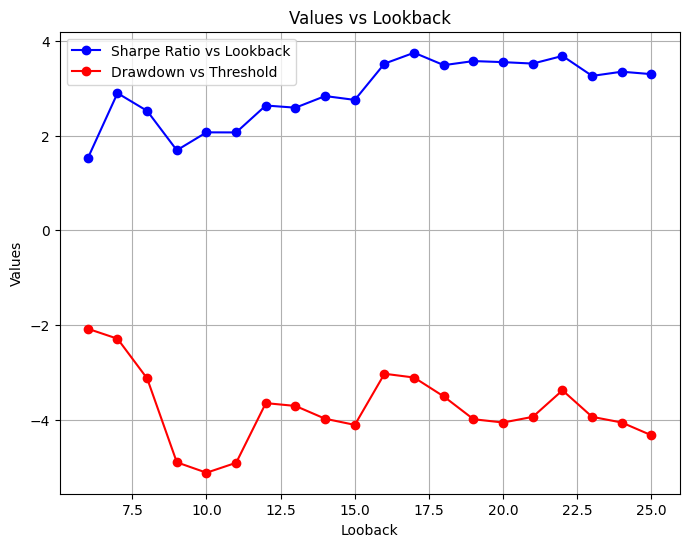

In [1003]:
X= np.arange(6,26,1)
Y1= [model(spread, option_close, lookback=i, threshold=1.5)['sharpe'] for i in X ]
Y2= [model(spread, option_close, lookback=i, threshold=1.5)['dd'] for i in X ]

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.plot(X, Y1, marker='o', linestyle='-', color='b', label='Sharpe Ratio vs Lookback')
plt.plot(X, Y2, marker='o', linestyle='-', color='r', label='Drawdown vs Threshold')

# Adding labels, title, and legend
plt.xlabel('Looback')
plt.ylabel('Values')
plt.title('Values vs Lookback')
plt.legend()

# Show grid and display the plot
plt.grid(True)
plt.show()

In [1074]:

#Logically selected features
result_matrix= model(spread, option_close, 13, 1.5, 1, 0)
print(result_matrix)


{'pnl': np.float64(6.5600000000000005), 'sharpe': np.float64(2.588691347821484), 'dd': np.float64(-3.709999999999999)}


In [1085]:
wt1,wt2,loss= gradient_descent(spread, option_close, 13, 1.5, learning_rate=0.01, epochs=100)

Epoch 0: Loss = -6.1000, wt1 = 0.9500, wt2 = 1.0120
Epoch 10: Loss = -21.3600, wt1 = 1.1300, wt2 = 2.2540
Epoch 20: Loss = -23.8400, wt1 = 1.5840, wt2 = 2.3900
Epoch 30: Loss = -23.6000, wt1 = 1.5920, wt2 = 2.5880
Epoch 40: Loss = -23.7700, wt1 = 1.2960, wt2 = 2.4400
Epoch 50: Loss = -23.2700, wt1 = 1.6980, wt2 = 2.6300
Epoch 60: Loss = -22.3400, wt1 = 1.2060, wt2 = 2.5100
Epoch 70: Loss = -23.9200, wt1 = 1.6260, wt2 = 2.6040
Epoch 80: Loss = -23.1500, wt1 = 1.8660, wt2 = 2.5120
Epoch 90: Loss = -22.8300, wt1 = 1.7920, wt2 = 2.4060
